## Lab 1

### Part 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
File ‘data.txt’ already there; not retrieving.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp 'drive/My Drive/Colab Notebooks/networks.py' .
# !cp 'drive/My Drive/Colab Notebooks/transformer.py' .
!cp 'drive/My Drive/Colab Notebooks/utils.py' .

In [5]:
if not os.path.exists('./utils.py'):
    print("utils file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/homeworks_advanced/Lab1_NLP/utils.py -nc

if not os.path.exists('./networks.py'):
    print("network file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/homeworks_advanced/Lab1_NLP/my_network.py -nc

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
plt.style.use('ggplot')

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [7]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [8]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [9]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [10]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [11]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [12]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9282
Unique tokens in target (en) vocabulary: 6734


Here are tokens from original (RU) corpus:

In [13]:
SRC.vocab.itos[::1000]

['<unk>',
 'еду',
 'базилика',
 'котор',
 'cala',
 'чистый',
 'mia',
 'фриули',
 'доберутся',
 'странд']

And from target (EN) corpus:

In [14]:
TRG.vocab.itos[::1000]

['<unk>', 'tastefully', 'gdansk', 'calm', 'nevskiy', 'sunway', 'massira']

And here is example from train dataset:

In [15]:
print(vars(train_data.examples[9]))

{'trg': ['maastricht', '-', 'aachen', 'airport', 'is', '13', '.', '1', 'km', 'away', 'and', 'the', 'property', 'offers', 'free', 'parking', '.'], 'src': ['расстояние', 'до', 'аэропорта', 'маастрихт', '-', 'аахен', 'составляет', '13', ',', '1', 'км', '.', 'гостям', 'предоставляется', 'бесплатная', 'парковка', '.']}


Let's check the length distributions:

Length distribution in Train data


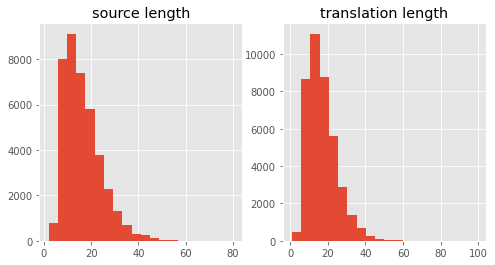

In [16]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


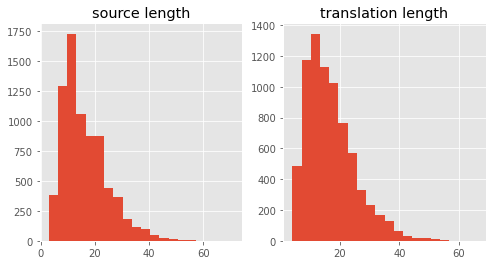

In [17]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
device

device(type='cuda')

In [20]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [21]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 49x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 47x128 (GPU 0)]
torch.Size([47, 128]) torch.Size([49, 128])


#### Simple Encoder-Decoder network

In [22]:
import networks

In [23]:
Encoder = networks.Encoder
Decoder = networks.Decoder
Seq2Seq = networks.Seq2Seq

In [24]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [25]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9282, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6734, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6734, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,911,054 trainable parameters


In [27]:
PAD_IDX = TRG.vocab.stoi['<pad>']
SOS_IDX = TRG.vocab.stoi['<sos>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
lr_scheduler = StepLR(optimizer=optimizer, step_size=3, gamma=0.5)

In [28]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [29]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
def train_model(model, train_iterator, valid_iterator, optimizer, criterion,
                lr_scheduler, n_epochs, clip, model_name="model.pth"):
    
    train_history = []
    valid_history = []
    best_valid_loss = float('inf')

    for epoch in range(n_epochs):
        
        start_time = time.time()
        
        train_loss = train(model, train_iterator, optimizer, criterion, clip, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)

        lr_scheduler.step(valid_loss)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_name)
        
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

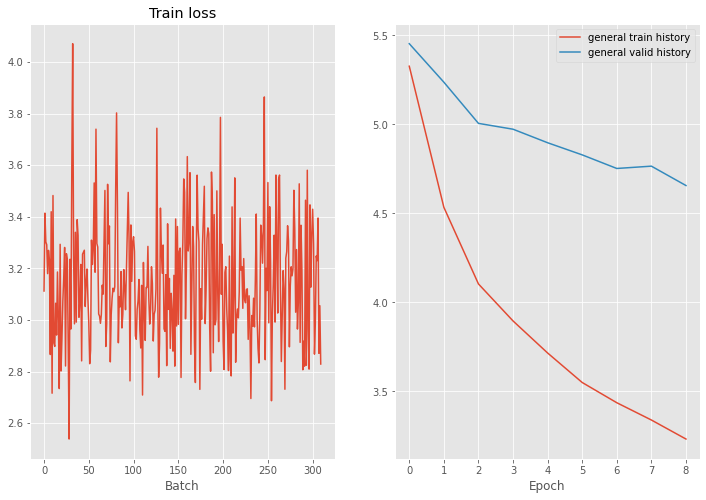

Epoch: 10 | Time: 1m 21s
	Train Loss: 3.147 | Train PPL:  23.261
	 Val. Loss: 4.670 |  Val. PPL: 106.649


In [32]:
train_model(model, train_iterator, valid_iterator, 
            optimizer, criterion, lr_scheduler, 
            n_epochs=10, clip=1, model_name="model.pt")

__Let's take a look at our network quality__:

In [33]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [34]:
batch = next(iter(test_iterator))

In [35]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: free wifi access is available .
Generated: free wifi access is available .

Original: bed linen is featured .
Generated: some rooms have a shared .



In [36]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [37]:
import tqdm

In [38]:
def get_generated_texts(model, test_iterator):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for i, batch in tqdm.tqdm(enumerate(test_iterator)):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)
            
            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

    return original_text, generated_text

In [39]:
orig_text_Seq2Seq, gen_text_Seq2Seq = get_generated_texts(model, test_iterator)

59it [00:03, 17.95it/s]


In [40]:
corpus_bleu([[text] for text in orig_text_Seq2Seq], gen_text_Seq2Seq) * 100

13.569694777693488

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

#### Using CNN as the Encoder

This is the usage of CNN as the Encoder and LSTM as a decoder in Seq2Seq model. The architecture of the CNN Encoder is as follows:

* `N_ENC_LAYERS` of convolutions with defined `KERNEL_SIZE`
* Every application of convolutional layer is followed by a residual connection and `ReLU` non-linearity
* Maximum over time pooling is applied after all encoder layers followed by a projection to desired dimension for the Decoder
* There is an ability to provide positional encoding for the Encoder

The Decoder is a simple LSTM recurrent neural network.

In [41]:
imp.reload(networks)

<module 'networks' from '/content/networks.py'>

In [42]:
EncoderCNN = networks.EncoderCNN
Decoder = networks.Decoder
CNN2RNN = networks.CNN2RNN

In [43]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
ENC_HID_DIM = 512
DEC_HID_DIM = 512
N_ENC_LAYERS = 5
N_DEC_LAYERS = 2
KERNEL_SIZE = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc_cnn = EncoderCNN(device=device,
                     input_dim=INPUT_DIM,
                     emb_dim=ENC_EMB_DIM,
                     hid_dim=ENC_HID_DIM,
                     num_layers=N_ENC_LAYERS,
                     out_dim=DEC_HID_DIM*4,
                     pos_encoding=True,
                     dropout_p=ENC_DROPOUT,
                     kernel_size=KERNEL_SIZE)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM, N_DEC_LAYERS, DEC_DROPOUT)

CNN2RNN_model = CNN2RNN(enc_cnn, dec, device).to(device)
print(f'The model has {count_parameters(CNN2RNN_model):,} trainable parameters')

The model has 20,842,574 trainable parameters


In [44]:
CNN2RNN_model.apply(init_weights)

CNN2RNN(
  (encoder): EncoderCNN(
    (embedding): Embedding(9282, 512)
    (conv): ModuleList(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (projection_layer): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (pooling): AdaptiveMaxPool1d(output_size=1)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (embedding): Embedding(6734, 512)
    (rnn): LSTM(512, 512, num_layers=2, dropout=0.1)
    (out): Linear(in_features=512, out_features=6734, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [45]:
optimizer_cnn = optim.AdamW(CNN2RNN_model.parameters())
criterion_cnn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler_cnn = ReduceLROnPlateau(optimizer=optimizer_cnn, patience=2, factor=0.2)

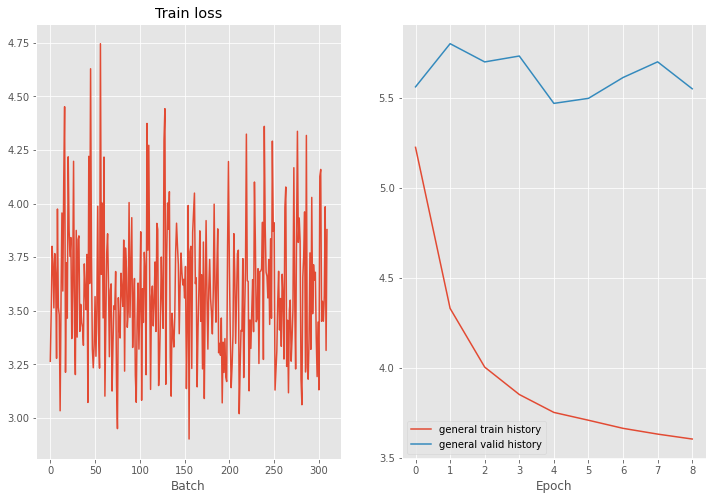

Epoch: 10 | Time: 1m 26s
	Train Loss: 3.587 | Train PPL:  36.133
	 Val. Loss: 5.571 |  Val. PPL: 262.609


In [46]:
train_model(CNN2RNN_model, train_iterator, valid_iterator, 
            optimizer_cnn, criterion_cnn, lr_scheduler_cnn, 
            n_epochs=10, clip=1, model_name="cnn_model.pt")

In [47]:
orig_text_CNN2RNN, gen_text_CNN2RNN = get_generated_texts(CNN2RNN_model, test_iterator)

59it [00:03, 16.29it/s]


In [48]:
corpus_bleu([[text] for text in orig_text_CNN2RNN], gen_text_CNN2RNN) * 100

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


3.398475122558496

The `BLEU` score is quite low. I assume that this is due to the following reasons:


*   It is not clear, how to properly use the produced vector from the CNN Encoder in LSTM Decoder. We have to somehow initialize cell and hidden state of the LSTM from this vector, because the input for Decoder is `SOS` token. It is not really obvious how to implement it. I managed to do this, however, I do not know whether it is correct or not. 
*   Maybe we should use different kernel sizes and experiment more with the number of layers.
*   Moreover, I tried to implement another type of CNN Encoder. It used different kernel sizes, the results from them were ran through `ReLU` and `AdaptiveMaxPool1d`, then concatenated and projected to the desired dimension for the decoder. I did not include it here, however, the results were almost the same. So it looks like the main issue is the first one in this task.


Maybe it will be useful to implement CNN Encoder without pooling on the top layer, but with Attention Mechanism for the Decoder.



#### Using Attention in Seq2Seq Model

I have decided to implement attention mechanism and apply it in Seq2Seq model with LSTM Encoder and LSTM decoder. 

In [49]:
imp.reload(networks)

<module 'networks' from '/content/networks.py'>

In [50]:
Encoder = networks.Encoder
DecoderAttention = networks.DecoderAttention
Seq2SeqAttention = networks.Seq2SeqAttention

In [51]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec_attention = DecoderAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model_attention = Seq2SeqAttention(enc, dec_attention, device).to(device)

In [52]:
model_attention.apply(init_weights)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(9282, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderAttention(
    (embedding): Embedding(6734, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention(
      (linear_in): Linear(in_features=512, out_features=512, bias=False)
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=512, out_features=6734, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [53]:
print(f'The model has {count_parameters(model_attention):,} trainable parameters')

The model has 15,697,486 trainable parameters


In [54]:
optimizer_attention = optim.AdamW(model_attention.parameters())
criterion_attention = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler_attention = ReduceLROnPlateau(optimizer=optimizer_attention, patience=2, factor=0.2)

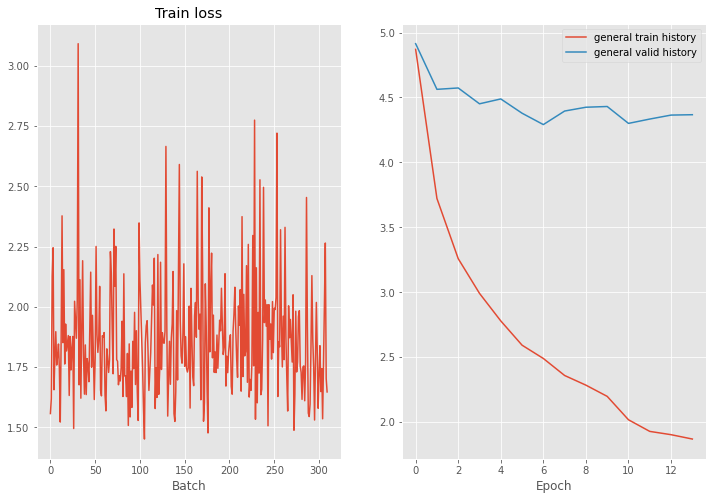

Epoch: 15 | Time: 1m 40s
	Train Loss: 1.867 | Train PPL:   6.467
	 Val. Loss: 4.386 |  Val. PPL:  80.330


In [55]:
train_model(model_attention, train_iterator, valid_iterator, 
            optimizer_attention, criterion_attention, lr_scheduler_attention, 
            n_epochs=15, clip=1, model_name="model_attention.pt")

In [56]:
orig_text_attention, gen_text_attention = get_generated_texts(model_attention, test_iterator)

59it [00:04, 14.58it/s]


In [57]:
corpus_bleu([[text] for text in orig_text_attention], gen_text_attention) * 100

32.48880334013645

In [58]:
for idx in [1, 2, 3, 4, 5]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model_attention, TRG.vocab)

Original: free wifi access is available .
Generated: free wifi access is available .

Original: bed linen is featured .
Generated: bed linen is featured .

Original: you will find a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk .

Original: there is a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk .

Original: there is a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk .



We see that this model achieved great results (`BLEU` is higher than 30). Of course it takes more time to train comparing to the baseline model, but the improvement is very significant. Also we see that the generated translation is quite nice comparing to the original sentence.

#### Transformer

I have decided to implement the class based on the Transformer architecture. I used PyTorch implementation of it (`nn.Transformer`). In this class the behaviour of Transformer during testing and training is not the same.

##### One transformer implementation

In [72]:
Seq2SeqTransformer = networks.Seq2SeqTransformer

In [73]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
NHEAD = 2
ENC_LAYERS = 2
DEC_LAYERS = 2
EMB_DIM = 512
DROPOUT = 0.2

model_transformer = Seq2SeqTransformer(INPUT_DIM, OUTPUT_DIM, EMB_DIM,
                                       NHEAD, ENC_LAYERS, DEC_LAYERS).to(device)

In [74]:
optimizer_transformer = optim.AdamW(model_transformer.parameters())
criterion_transformer = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler_transformer = ReduceLROnPlateau(optimizer=optimizer_transformer, patience=2, factor=0.2)

In [75]:
print(f'The model has {count_parameters(model_transformer):,} trainable parameters')

The model has 26,369,615 trainable parameters


In [76]:
def init_weights_transformer(m):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

In [77]:
model_transformer.apply(init_weights_transformer)

Seq2SeqTransformer(
  (enc_emb): Embedding(9282, 512)
  (dec_emb): Embedding(6734, 512)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_model): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
      

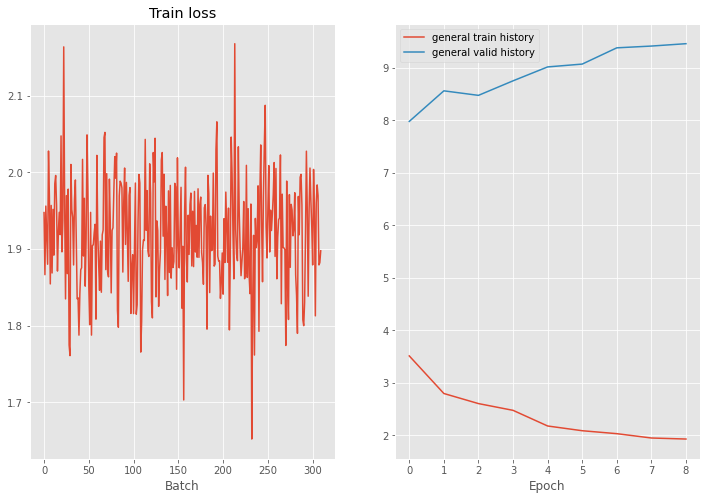

Epoch: 10 | Time: 1m 7s
	Train Loss: 1.919 | Train PPL:   6.817
	 Val. Loss: 9.487 |  Val. PPL: 13193.027


In [78]:
train_model(model_transformer, train_iterator, valid_iterator, 
            optimizer_transformer, criterion_transformer, 
            lr_scheduler_transformer, n_epochs=10, clip=1, 
            model_name="model_transformer.pt")

In [79]:
orig_text_transformer, gen_text_transformer = get_generated_texts(model_transformer, test_iterator)

59it [00:21,  2.73it/s]


In [80]:
corpus_bleu([[text] for text in orig_text_transformer], gen_text_transformer) * 100

10.717154766941867

In [68]:
for idx in [1, 2, 3, 4, 5]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model_transformer, TRG.vocab)

Original: free wifi access is available .
Generated: wi - fi access is available .

Original: bed linen is featured .
Generated: linen is featured .

Original: you will find a 24 - hour front desk at the property .
Generated: is a 24 - hour front desk at the property .

Original: there is a 24 - hour front desk at the property .
Generated: is a 24 - hour front desk at the property .

Original: there is a 24 - hour front desk at the property .
Generated: is a 24 - hour front desk at the property .



In different settings for class parameters the training process almost looked the same. Validation loss almost did not change during the epochs, or even increased sometimes. There should be added more regularization techniques and tricks, which were implemented in original transformer. As  I understood, it is quite sensitive to these things. I discovered that sometimes it produces sentences with the repeated for many times ending. It is quite possible, that there is a mistake in my implementation.

##### Another Transformer implementation

I was discovering how to use Transformers properly for Machine Translation. As I understood, the behaviour of Decoder during training and testing time is not the same. However, I have found an implementation, where there was no difference. I have rewritten it, but the idea remained the same. It was interesting, what is the difference between these models.

In [218]:
imp.reload(networks)

<module 'networks' from '/content/networks.py'>

In [219]:
LanguageTransformer = networks.LanguageTransformer

In [220]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
NHEAD = 2
ENC_LAYERS = 2
DEC_LAYERS = 2
EMB_DIM = 512
DROPOUT = 0.2

language_transformer = LanguageTransformer(INPUT_DIM, OUTPUT_DIM, EMB_DIM,
                                        NHEAD, ENC_LAYERS, DEC_LAYERS).to(device)

In [221]:
optimizer_language_transformer = optim.AdamW(language_transformer.parameters())
criterion_language_transformer = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler_language_transformer = ReduceLROnPlateau(optimizer=optimizer_language_transformer, patience=2, factor=0.2)

In [222]:
print(f'The model has {count_parameters(language_transformer):,} trainable parameters')

The model has 26,369,615 trainable parameters


In [223]:
def train_new_transformer(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

    return epoch_loss / len(iterator)


def evaluate_transformer(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


def train_transformer(model, train_iterator, valid_iterator, optimizer, criterion,
                lr_scheduler, n_epochs, clip, model_name="model.pth"):
    
    train_history = []
    valid_history = []
    best_valid_loss = float('inf')

    for epoch in range(n_epochs):
        
        start_time = time.time()
        
        train_loss = train_new_transformer(model, train_iterator, optimizer, criterion, clip, train_history, valid_history)
        valid_loss = evaluate_transformer(model, valid_iterator, criterion)

        lr_scheduler.step(valid_loss)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_name)
        
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

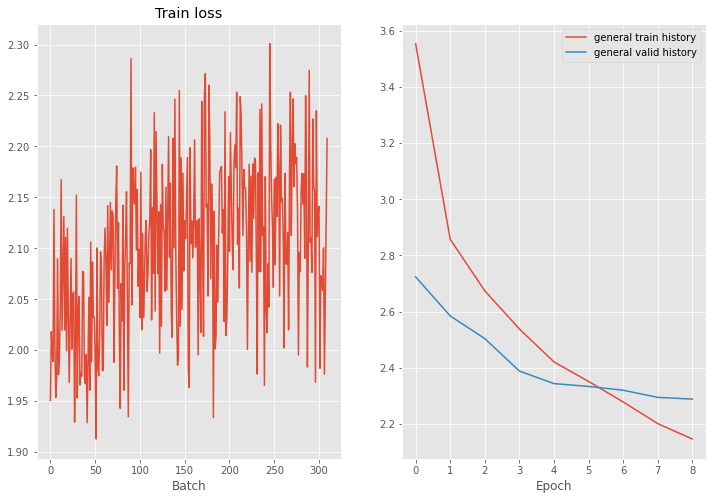

Epoch: 10 | Time: 1m 0s
	Train Loss: 2.099 | Train PPL:   8.157
	 Val. Loss: 2.300 |  Val. PPL:   9.973


In [224]:
train_transformer(language_transformer, train_iterator, valid_iterator, 
                  optimizer_language_transformer, criterion_language_transformer, 
                  lr_scheduler_language_transformer, n_epochs=10, clip=1, 
                  model_name="model_transformer.pt")

In [225]:
def get_generated_texts_transformer(model, test_iterator):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for i, batch in tqdm.tqdm(enumerate(test_iterator)):

            src = batch.src
            trg = batch.trg

            output = model(src, trg) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)
            
            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

    return original_text, generated_text

In [226]:
orig_text_transformer, gen_text_transformer = get_generated_texts_transformer(language_transformer, test_iterator)

59it [00:01, 33.13it/s]


In [227]:
corpus_bleu([[text] for text in orig_text_transformer], gen_text_transformer) * 100

17.91973173841028

In [228]:
def generate_translation_transformer(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = get_text(list(trg[:,0].cpu().numpy()), TRG_vocab)
    generated = get_text(list(output[1:, 0]), TRG_vocab)
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

In [229]:
for idx in [1, 2, 3, 4, 5]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation_transformer(src, trg, language_transformer, TRG.vocab)

Original: free wifi access is available .
Generated: wi access is available .

Original: bed linen is featured .
Generated: linen is provided .

Original: you will find a 24 - hour front desk at the property .
Generated: will find a 24 - hour front desk at the property .

Original: there is a 24 - hour front desk at the property .
Generated: is a 24 - hour front desk at the property .

Original: there is a 24 - hour front desk at the property .
Generated: is a 24 - hour front desk at the property .



The training process looked a bit strange. As I understand, the evaluation should proceed like in another Transformer model in autoregressive setting. I do not completely understand the desired pipeline of working with nn.TransformerEncoder and nn.TransformerDecoder. However, the `BLEU` score and generated translations are not bad.

### Conclusions

* There were tested a several models for translation task: simple Encoder-Decoder network, CNN-Encoder based (with ability of positional encoding), LSTM-LSTM with Attention, two implementations of Transformer architecture. The best score `BLEU` (over 30) was obtained by LSTM-LSTM network with Attention. 
* As I understood from some articles, using `BERT` as the Encoder for Machine Translation might face some problems and it is hard to utilize it to make a translation quality better.
* Possible improvements include using Byte Pair Encoding, applying pre-trained embeddings for languages and maybe then training them along with the model.